# Example 2: Entangling quantum gates for coupled transmon qubits

$
\newcommand{tr}[0]{\operatorname{tr}}
\newcommand{diag}[0]{\operatorname{diag}}
\newcommand{abs}[0]{\operatorname{abs}}
\newcommand{pop}[0]{\operatorname{pop}}
\newcommand{aux}[0]{\text{aux}}
\newcommand{opt}[0]{\text{opt}}
\newcommand{tgt}[0]{\text{tgt}}
\newcommand{init}[0]{\text{init}}
\newcommand{lab}[0]{\text{lab}}
\newcommand{rwa}[0]{\text{rwa}}
\newcommand{bra}[1]{\langle#1\vert}
\newcommand{ket}[1]{\vert#1\rangle}
\newcommand{Bra}[1]{\left\langle#1\right\vert}
\newcommand{Ket}[1]{\left\vert#1\right\rangle}
\newcommand{Braket}[2]{\left\langle #1\vphantom{#2}\mid{#2}\vphantom{#1}\right\rangle}
\newcommand{op}[1]{\hat{#1}}
\newcommand{Op}[1]{\hat{#1}}
\newcommand{dd}[0]{\,\text{d}}
\newcommand{Liouville}[0]{\mathcal{L}}
\newcommand{DynMap}[0]{\mathcal{E}}
\newcommand{identity}[0]{\mathbf{1}}
\newcommand{Norm}[1]{\lVert#1\rVert}
\newcommand{Abs}[1]{\left\vert#1\right\vert}
\newcommand{avg}[1]{\langle#1\rangle}
\newcommand{Avg}[1]{\left\langle#1\right\rangle}
\newcommand{AbsSq}[1]{\left\vert#1\right\vert^2}
\newcommand{Re}[0]{\operatorname{Re}}
\newcommand{Im}[0]{\operatorname{Im}}
$

In [1]:
using DrWatson
@quickactivate "GRAPETests"
using QuantumControl

This example illustrates the optimization towards a perfectly entangling
two-qubit gate for a system of two transmon qubits with a shared transmission
line. It goes through three progressively more advanced optimizations:

1. The direct optimization for a $\Op{O} = \sqrt{\text{iSWAP}}$ gate with a
   standard square-modulus functional
2. The optimization towards a perfect entangler using the functional
   developed in Goerz et al., Phys. Rev. A 91, 062307 (2015)
3. The direct maximization of of the gate concurrence

While the first example evaluates the gradient of the optimization functional
analytically, the latter two are examples for the use of automatic
differentiation, or more specifically semi-automatic differentiation, as
developed in Goerz et al., arXiv:2205.15044. The optimization of the gate
concurrence specifically illustrates the optimization of a functional that is
inherently non-analytical.

## Hamiltonian and guess pulses

We will write the Hamiltonian in units of GHz (angular frequency; the factor
2π is implicit) and ns:

In [2]:
const GHz = 2π
const MHz = 0.001GHz
const ns = 1.0
const μs = 1000ns;

The Hamiltonian and parameter are taken from Goerz et. al., Phys. Rev. A 91,
062307 (2015)., cf. Table 1 in that Reference.

In [3]:
⊗ = kron
const 𝕚 = 1im
const N = 6  # levels per transmon

using LinearAlgebra
using SparseArrays

function hamiltonian(;
    Ωre,
    Ωim,
    N=N,  # levels per transmon
    ω₁=4.380GHz,
    ω₂=4.614GHz,
    ωd=4.498GHz,
    α₁=-210MHz,
    α₂=-215MHz,
    J=-3MHz,
    λ=1.03,
    use_sparse=:auto
)
    𝟙 = SparseMatrixCSC{ComplexF64,Int64}(sparse(I, N, N))
    b̂₁ = spdiagm(1 => complex.(sqrt.(collect(1:N-1)))) ⊗ 𝟙
    b̂₂ = 𝟙 ⊗ spdiagm(1 => complex.(sqrt.(collect(1:N-1))))
    b̂₁⁺ = sparse(b̂₁')
    b̂₂⁺ = sparse(b̂₂')
    n̂₁ = sparse(b̂₁' * b̂₁)
    n̂₂ = sparse(b̂₂' * b̂₂)
    n̂₁² = sparse(n̂₁ * n̂₁)
    n̂₂² = sparse(n̂₂ * n̂₂)
    b̂₁⁺_b̂₂ = sparse(b̂₁' * b̂₂)
    b̂₁_b̂₂⁺ = sparse(b̂₁ * b̂₂')

    ω̃₁ = ω₁ - ωd
    ω̃₂ = ω₂ - ωd

    Ĥ₀ = sparse(
        (ω̃₁ - α₁ / 2) * n̂₁ +
        (α₁ / 2) * n̂₁² +
        (ω̃₂ - α₂ / 2) * n̂₂ +
        (α₂ / 2) * n̂₂² +
        J * (b̂₁⁺_b̂₂ + b̂₁_b̂₂⁺)
    )

    Ĥ₁re = (1 / 2) * (b̂₁ + b̂₁⁺ + λ * b̂₂ + λ * b̂₂⁺)
    Ĥ₁im = (𝕚 / 2) * (b̂₁⁺ - b̂₁ + λ * b̂₂⁺ - λ * b̂₂)

    if ((N < 5) && (use_sparse ≢ true)) || use_sparse ≡ false
        H = (Array(Ĥ₀), (Array(Ĥ₁re), Ωre), (Array(Ĥ₁im), Ωim))
    else
        H = (Ĥ₀, (Ĥ₁re, Ωre), (Ĥ₁im, Ωim))
    end
    return H

end;

We choose a pulse duration of 400 ns. The guess pulse amplitude is 35 MHz,
with a 15 ns switch-on/-off time. The Hamiltonian is written in a rotating
frame, so in general, the control field is allowed to be complex-valued. We
separate this into two control fields, one for the real part and one for the
imaginary part. Initially, the imaginary part is zero, corresponding to a
field exactly at the frequency of the rotating frame.

In [4]:
using QuantumControl.Shapes: flattop

function guess_pulses(; T=400ns, E₀=35MHz, dt=0.1ns, t_rise=15ns)

    tlist = collect(range(0, T, step=dt))
    Ωre = t -> E₀ * flattop(t, T=T, t_rise=t_rise)
    Ωim = t -> 0.0

    return tlist, Ωre, Ωim

end

tlist, Ωre_guess, Ωim_guess = guess_pulses();

We can visualize this:

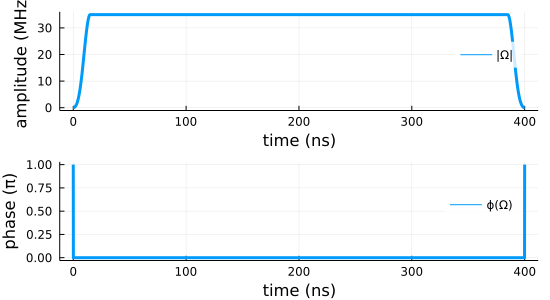

In [5]:
using Plots
Plots.default(
    linewidth               = 3,
    size                    = (550, 300),
    legend                  = :right,
    foreground_color_legend = nothing,
    background_color_legend = RGBA(1, 1, 1, 0.8),
)

function plot_complex_pulse(tlist, Ω; time_unit=:ns, ampl_unit=:MHz, kwargs...)

    ax1 = plot(
        tlist ./ eval(time_unit),
        abs.(Ω) ./ eval(ampl_unit);
        label="|Ω|",
        xlabel="time ($time_unit)",
        ylabel="amplitude ($ampl_unit)",
        kwargs...
    )

    ax2 = plot(
        tlist ./ eval(time_unit),
        angle.(Ω) ./ π;
        label="ϕ(Ω)",
        xlabel="time ($time_unit)",
        ylabel="phase (π)"
    )

    plot(ax1, ax2, layout=(2, 1))

end

plot_complex_pulse(tlist, Ωre_guess.(tlist) + 𝕚 * Ωim_guess.(tlist))

We now instantiate the Hamiltonian with these control fields:

In [6]:
H = hamiltonian(Ωre=Ωre_guess, Ωim=Ωim_guess);

## Logical basis for two-qubit gates

For simplicity, we will be define the qubits in the *bare* basis, i.e.
ignoring the static coupling $J$.

In [7]:
function ket(i::Int64; N=N)
    Ψ = zeros(ComplexF64, N)
    Ψ[i+1] = 1
    return Ψ
end

function ket(indices::Int64...; N=N)
    Ψ = ket(indices[1]; N=N)
    for i in indices[2:end]
        Ψ = Ψ ⊗ ket(i; N=N)
    end
    return Ψ
end

function ket(label::AbstractString; N=N)
    indices = [parse(Int64, digit) for digit in label]
    return ket(indices...; N=N)
end;

In [8]:
basis = [ket("00"), ket("01"), ket("10"), ket("11")];

## Optimizing for a specific quantum gate

Our target gate is $\Op{O} = \sqrt{\text{iSWAP}}$:

In [9]:
SQRTISWAP = [
    1  0    0   0
    0 1/√2 𝕚/√2 0
    0 𝕚/√2 1/√2 0
    0  0    0   1
];

For each basis state, we get a target state that results from applying the
gate to the basis state (you can convince yourself that this equivalent
multiplying the transpose of the above gate matrix to the vector of basis
states):

In [10]:
basis_tgt = transpose(SQRTISWAP) * basis;

The mapping from each initial (basis) state to the corresponding target state
constitutes an "objective" for the optimization:

In [11]:
objectives = [
    Objective(initial_state=Ψ, target_state=Ψtgt, generator=H) for
    (Ψ, Ψtgt) ∈ zip(basis, basis_tgt)
];

We can analyze how all of the basis states evolve under the guess controls in
one go:

In [12]:
using QuantumControl: propagate_objectives

guess_states = propagate_objectives(objectives, tlist; use_threads=true);

The gate implemented by the guess controls is

In [13]:
U_guess = [basis[i] ⋅ guess_states[j] for i = 1:4, j = 1:4];

We will optimize these objectives with a square-modulus functional

In [14]:
using QuantumControl.Functionals: J_T_sm

The initial value of the functional is

In [15]:
J_T_sm(guess_states, objectives)

0.9156372510988784

which is the gate error

In [16]:
1 - (abs(tr(U_guess' * SQRTISWAP)) / 4)^2

0.9156372510988784

Now, we define the full optimization problems on top of the list of
objectives, and with the optimization functional:

In [17]:
problem = ControlProblem(
    objectives=objectives,
    tlist=tlist,
    iter_stop=100,
    J_T=J_T_sm,
    check_convergence=res -> begin
        (
            (res.J_T > res.J_T_prev) &&
            (res.converged = true) &&
            (res.message = "Loss of monotonic convergence")
        )
        ((res.J_T <= 1e-3) && (res.converged = true) && (res.message = "J_T < 10⁻³"))
    end,
    use_threads=true,
);

In [18]:
opt_result, file =
    @optimize_or_load(datadir(), problem; method=:GRAPE, filename="GATE_OCT.jld2");

In [19]:
opt_result

GRAPE Optimization Result
-------------------------
- Started at 2022-09-06T23:37:36.446
- Number of objectives: 4
- Number of iterations: 38
- Number of pure func evals: 0
- Number of func/grad evals: 49
- Value of functional: 6.38697e-04
- Reason for termination: J_T < 10⁻³
- Ended at 2022-09-06T23:41:19.699 (3 minutes, 43 seconds, 253 milliseconds)


We extract the optimized control field from the optimization result and plot
it

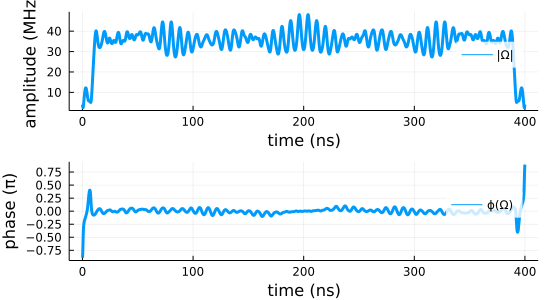

In [20]:
Ω_opt = opt_result.optimized_controls[1] + 𝕚 * opt_result.optimized_controls[2]

plot_complex_pulse(tlist, Ω_opt)

We then propagate the optimized control field to analyze the resulting
quantum gate:

In [21]:
opt_states = propagate_objectives(
    objectives,
    tlist;
    use_threads=true,
    controls_map=IdDict(
        Ωre_guess => opt_result.optimized_controls[1],
        Ωim_guess => opt_result.optimized_controls[2]
    )
);

The resulting gate is

In [22]:
U_opt = [basis[i] ⋅ opt_states[j] for i = 1:4, j = 1:4];

and we can verify the resulting fidelity

In [23]:
(abs(tr(U_opt' * SQRTISWAP)) / 4)^2

0.9993613032446665

## Optimizing for a general perfect entangler

We define the optimization with one objective for each of the four basis
states:

In [24]:
objectives = [Objective(; initial_state=Ψ, generator=H) for Ψ ∈ basis];

Note that we omit the `target_state` here. This is because we will be
optimizing for an arbitrary perfect entangler, not for a specific quantum
gate. Thus, there is no a-priori known target state to which the initial
state must evolve.

The optimization is steered by the perfect entanglers distance measure
$D_{PE}$, that is, the geometric distance of the quantum gate obtained from
propagating the four basis states to the polyhedron of perfect entanglers in
the Weyl chamber. Since the logical subspace defining the qubit is embedded
in the larger Hilbert space of the transmon, there may be loss of population
from the logical subspace. To counter this possibility in the optimization,
we add a unitarity measure  to $D_{PE}$. The two terms are added with equal
weight.

In [25]:
using QuantumControl.WeylChamber: D_PE, gate_concurrence, unitarity
using QuantumControl.Functionals: gate_functional

J_T_PE = gate_functional(D_PE; unitarity_weight=0.5);

The `gate_functional` routines used above converts the function `D_PE` that
receives the gate $Û$ as a 4×4 matrix into a functional of the correct from
for the `QuantumControl.optimize` routine, which is a function of the
propagated states.

We can check that for the guess pulse, we are not implementing a perfect
entangler

In [26]:
gate_concurrence(U_guess)

0.7773116198516823

We find that the guess pulse produces a gate in the `W0*` region of the Weyl
chamber:

In [27]:
using QuantumControl.WeylChamber: weyl_chamber_region
weyl_chamber_region(U_guess)

"W0*"

That is, the region of the Weyl chamber containing controlled-phase gates with
a phase $> π$ (Weyl chamber coordinates $c₁ > π/2$, $c₂ < π/4$).

This in fact allows use to use the perfect entangler functional without
modification: if the guess pulse were in the "W1" region of the Weyl chamber,
(close to SWAP), we would have to flip its sign, or we would optimize towards
the local equivalence class of the SWAP gate instead of towards the perfect
of perfect entanglers. In principle, we could use a modified functional that
takes the absolute square of the `D_PE` term, by using

```
J_T_PE = gate_functional(D_PE; unitarity_weight=0.5, absolute_square=true)
```

This would specifically optimize for the *surface* of the perfect
entanglers functional.

The guess pulse loses about 10% of population from the logical subspace:

In [28]:
1 - unitarity(U_guess)

0.0907166459382196

We can also evaluate the geometric distance to the polyhedron of perfect
entanglers in the Weyl chamber:

In [29]:
D_PE(U_guess)

0.7787454222380431

Together with the unitarity measure, this is the initial value of the
optimization functional:

In [30]:
0.5 * D_PE(U_guess) + 0.5 * (1 - unitarity(U_guess))

0.43473103408813135

In [31]:
J_T_PE(guess_states, objectives)

0.43473103408813135

Now, we formulate the full control problem

In [32]:
problem = ControlProblem(
    objectives=objectives,
    tlist=tlist,
    iter_stop=100,
    J_T=J_T_PE,
    gradient_via=:chi,
    check_convergence=res -> begin
        (
            (res.J_T > res.J_T_prev) &&
            (res.converged = true) &&
            (res.message = "Loss of monotonic convergence")
        )
        (
            (res.J_T <= 1e-3) &&
            (res.converged = true) &&
            (res.message = "Found a perfect entangler")
        )
    end,
    use_threads=true,
);

Note that we have not specified a routine to calculate the gradient.
In  this case, our implementation of GRAPE will use automatic
differentiation, or actually "semi-automatic differentiation",
to calculate the gradient directly from the functional.

By semi-automatic differentiation, we mean that when we consider the
functional as a function of a set of states $\{|ϕ_k(T)⟩\}$, we find

$$
(∇J_T)_{ln} ≡ \frac{∂J_T(\{|ϕ_k(T)⟩\})}{∂ϵ_{ln}}
 = 2\Re\sum_k
    \frac{∂J_T}{∂|ϕ_k(T)⟩}
    \frac{∂|ϕ_k(T)⟩}{∂ϵ_{ln}}
$$

We can see that $\frac{∂J_T}{∂|ϕ_k(T)⟩}$ is very closely related to
the definition $|χ_k⟩ = -∂J_T/∂⟨ϕ_k|$ (up to the sign) that is a core part
of [Krotov's method](https://github.com/JuliaQuantumControl/Krotov.jl) (an
alternative optimization method to GRAPE). Our GRAPE
implementation knows about this, too. It will detect whether `J_T` is a
direct function of the forward-propagated states $|ϕ_k(T)⟩$. It does this
by checking whether the objectives define a target state. If they do, this
indicates that `J_T` is a direct function of overlaps $τ_k$. If they do not
(our case, see the absence of the `target_state` keyword argument when
defining the objectives above), `J_T` is considered a
direct function of $\{|ϕ_k(T)⟩\}$. GRAPE will then look for a
parameter `chi` that implements the above definition, or use automatic
differentiation to generate one, which is what happens in this example.

Once $\frac{∂J_T}{∂|ϕ_k(T)⟩}$ has been calculated, GRAPE is able to
analytically determine the full gradient $(∇J_T)_{ln}$ without any further
use of automatic differentiation.

With this, we can easily find a solution to the control problem:

In [33]:
opt_result, file =
    @optimize_or_load(datadir(), problem; method=:GRAPE, filename="PE_OCT.jld2");

In [34]:
opt_result

GRAPE Optimization Result
-------------------------
- Started at 2022-03-23T00:49:36.454
- Number of objectives: 4
- Number of iterations: 8
- Number of pure func evals: 0
- Number of func/grad evals: 10
- Value of functional: -4.31806e-03
- Reason for termination: Found a perfect entangler
- Ended at 2022-03-23T00:50:53.307 (1 minute, 16 seconds, 853 milliseconds)


We extract the optimized control field from the optimization result and plot
it

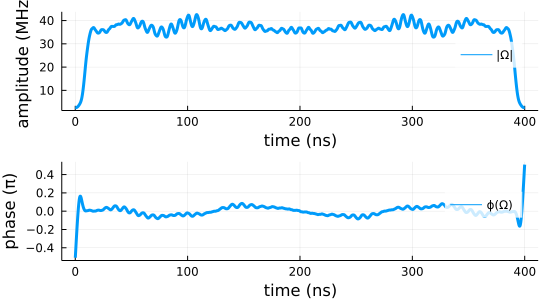

In [35]:
Ω_opt = opt_result.optimized_controls[1] + 𝕚 * opt_result.optimized_controls[2]

plot_complex_pulse(tlist, Ω_opt)

We then propagate the optimized control field to analyze the resulting
quantum gate:

In [36]:
opt_states = propagate_objectives(
    objectives,
    tlist;
    use_threads=true,
    controls_map=IdDict(
        Ωre_guess => opt_result.optimized_controls[1],
        Ωim_guess => opt_result.optimized_controls[2]
    )
);

U_opt = [basis[i] ⋅ opt_states[j] for i = 1:4, j = 1:4];

We find that we have achieved a perfect entangler:

In [37]:
gate_concurrence(U_opt)

1.0

Moreover, we have reduced the population loss to less than 2%

In [38]:
1 - unitarity(U_opt)

0.017510262840334967

## Direct maximization of the gate concurrence

In the previous optimizations, we have optimized for a perfect entangler
indirectly via a geometric function in the Weyl chamber. The entire reason
that perfect entangler functional was formulated is because calculating the
gate concurrence directly involves the eigenvalues of the unitary, see
Kraus, Cirac, Phys. Rev. A 63, 062309 (2001) and
Childs et al., PRA 68, 052311 (2003), which are inherently non-analytic.

However, since we are able to obtain gradient from automatic differentiation,
this is no longer an insurmountable obstacle

We can define a functional for a given gate `U` that combines the gate
concurrence and (as above) a unitarity measure to penalize loss of population
from the logical subspace:

In [39]:
J_T_C = U -> 0.5 * (1 - gate_concurrence(U)) + 0.5 * (1 - unitarity(U));

In the optimization, we will convert this functional to one that takes the
propagated states as arguments (via the `gate_functional` routine).
We can help the automatic differentiation making the same conversion "by
hand". As discussed above, without further intervention, out GRAPE
implementation will use automatic differentiation to calculate a state
$|χ_k⟩ = -\frac{∂}{∂⟨ϕ_k|} J_T$. Here, we can treat `J_T` as depending on
the gate `U` and apply the chain rule:

$$
\begin{split}
    |χ_k⟩
    &= - \frac{1}{2} \sum_i (∇_U J_T)_{ik} \frac{∂ U_{ik}}{∂⟨ϕ_k|} \\
    &= - \frac{1}{2} \sum_i (∇_U J_T)_{ik} |Ψ_i⟩
\end{split}
$$

The automatic differentiation now only has to calculate $(∇_U J_T)_{ik}$,
which is a much smaller-dimensional problem. The above chain rule is
implemented like this:

In [40]:
using QuantumControl.Functionals: make_gate_chi

chi_C = make_gate_chi(J_T_C, objectives);

which we can pass explicitly to the optimization.

Running the optimization, we again are able to find a perfect entangler.

In [41]:
opt_result_direct, file = @optimize_or_load(
    datadir(),
    problem;
    method=:GRAPE,
    J_T=gate_functional(J_T_C),
    gradient_via=:chi,
    chi=chi_C,
    filename="PE_OCT_direct.jld2"
);

In [42]:
opt_result_direct

GRAPE Optimization Result
-------------------------
- Started at 2022-03-23T00:50:54.124
- Number of objectives: 4
- Number of iterations: 13
- Number of pure func evals: 0
- Number of func/grad evals: 17
- Value of functional: 9.60569e-04
- Reason for termination: Found a perfect entangler
- Ended at 2022-03-23T00:52:47.895 (1 minute, 53 seconds, 771 milliseconds)


In [43]:
opt_states_direct = propagate_objectives(
    objectives,
    tlist;
    use_threads=true,
    controls_map=IdDict(
        Ωre_guess => opt_result_direct.optimized_controls[1],
        Ωim_guess => opt_result_direct.optimized_controls[2]
    )
);

U_opt_direct = [basis[i] ⋅ opt_states_direct[j] for i = 1:4, j = 1:4];

In [44]:
gate_concurrence(U_opt_direct)

0.9999992424611753

In [45]:
1 - unitarity(U_opt_direct)

0.0019203801880230964

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*